# Wright-Fisher Simulations

*in progress*

## Imports / configuration


In [ ]:
#%load_ext autoreload

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import GPy as gp

#%autoreload 2

# import helper functions
import sys
sys.path.append("src")
import simulator as sim
import likopt as opt

# configure plot style
sns.set_context("poster")
sns.set_style("whitegrid", 
              {"axes.facecolor": "1.0", 
               "axes.edgecolor": "0.5",
               "grid.linestyle": "-",
              })
plt.style.use("whitegrid.mplstyle")

## Simulation

Simulate allele frequencies

In [2]:
p = 20000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # number of generations to sim 700*25 17500
F = sim.simulate_frequencies(p, n_e, max_gen)

Simulate genotypes

In [3]:
n = 20 # number of sampled individuals

# sampled time points
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)

Simulate reads

In [4]:
eps = .01 # error rate
lamb = 2 # average coverage
Y, C = sim.simulate_reads(X, eps, lamb)

Plot a hist of the coverage distribution for a the first individual

17298


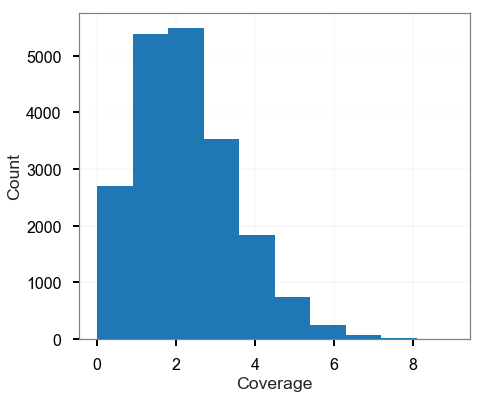

In [18]:
i = 5
plt.hist(C[i,:]);
print(np.sum(C[i,:]>0))
plt.xlabel("Coverage");
plt.ylabel("Count");

Plot some example trajectories

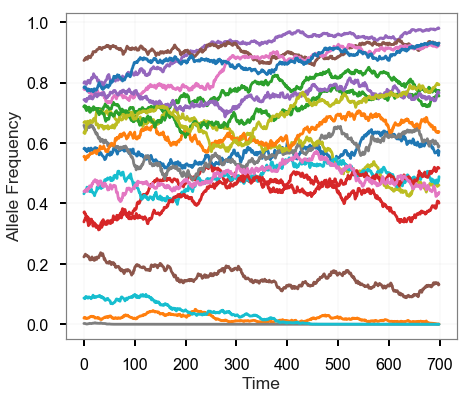

In [19]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(max_gen), F[:,j])
    
plt.xlabel("Time");
plt.ylabel("Allele Frequency");

Compute the population heterozygosity

In [7]:
H = 2 * F * (1 - F) # for all time points
h_true = np.sum(H, axis=1) / p
h = h_true[t] # for sampled time points

Compute an estimate of heterozygosity and  from the reads

In [8]:
%%time

h_hat = np.empty(n)
sigma2 = np.empty(n)

for i in range(n):
    print(i)
    L = opt.comp_lik_mat(Y[i,:], C[i,:], .01)
    pi_hat = opt.est_freq_read(L)
    h_hat[i] = pi_hat[1]
    I = opt.comp_fish_info(L, pi_hat)
    sigma2[i] = opt.comp_lik_var(I, p)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 1min 18s, sys: 1min 19s, total: 2min 38s
Wall time: 2min 38s


Plot population heterozygosity against time

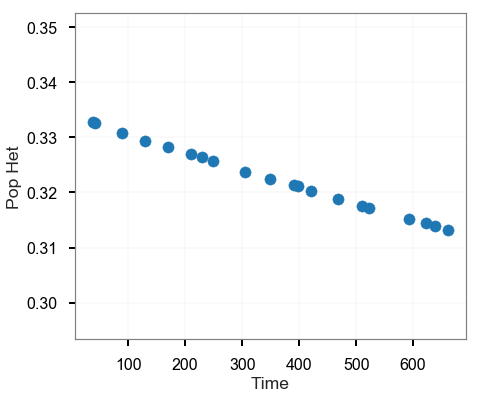

In [20]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("Pop Het");

Plot estimated heterozygosity against time

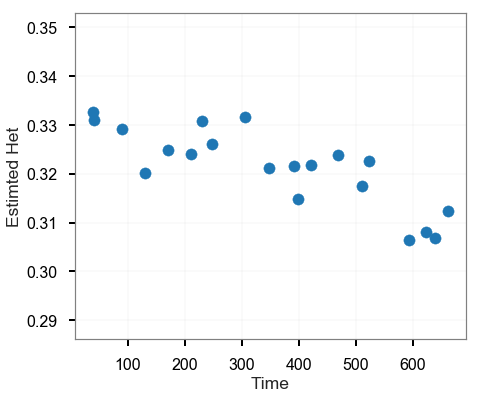

In [21]:
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Estimted Het");

Text(0,0.5,'-log10(variance)')

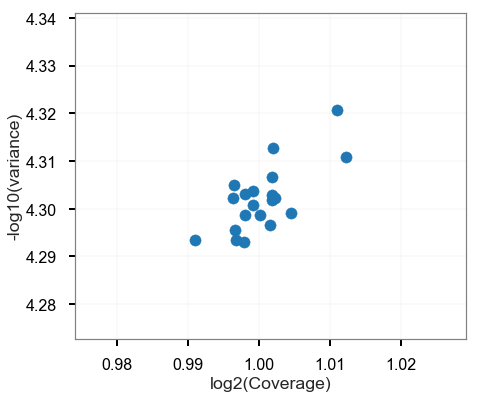

In [22]:
plt.scatter(np.log2(np.mean(C, axis=1)), -np.log10(sigma2))
plt.xlabel("log2(Coverage)")
plt.ylabel("-log10(variance)")

## Inference

Fit a Gaussian Process regression model with a Matern kernal. We use an emprical Bayes approach where the marginal likelihood is maximized to estimate hyper parameters of the covariance kernal and then posterior is then analytically computed ...

In [46]:
kern = gp.kern.Matern52(1)
#kern = gp.kern.Exponential(1)
model = gp.models.GPHeteroscedasticRegression(t[:,None], h_hat[:,None], kern) # set the model

model.het_Gauss.variance = sigma2[:,None] 
model.het_Gauss.variance.fix()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [47]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 81.3 ms, sys: 448 µs, total: 81.7 ms
Wall time: 84.6 ms


Fitting this is incredibly quick!

## Critique


Here is a plot of the posterior mean and variance output by the analytical posterior of the Gaussian Process model

 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


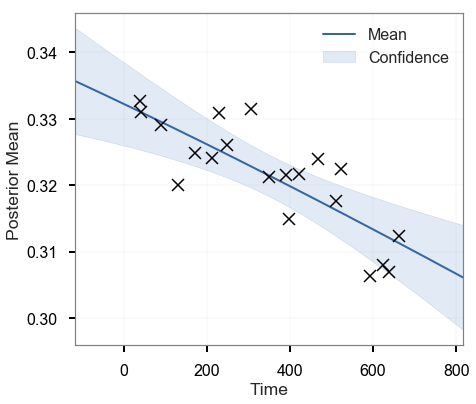

In [48]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx', mew=1.5);

0.9991098254996349

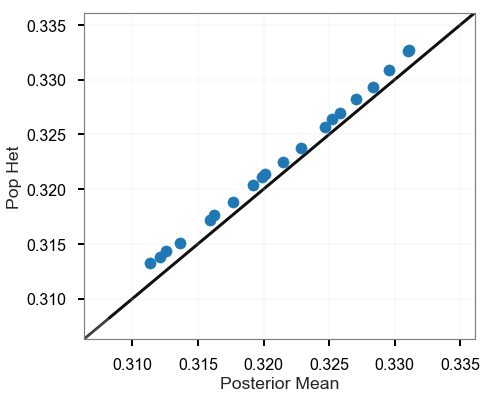

In [49]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
plt.xlabel("Posterior Mean")
plt.ylabel("Pop Het")

np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

0.8189707468145351

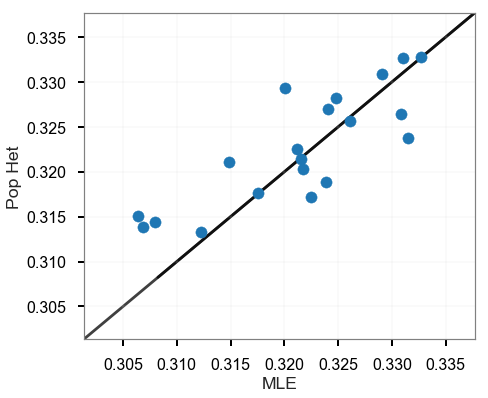

In [50]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
plt.xlabel("MLE")
plt.ylabel("Pop Het")

np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]